In [1]:
import nibabel as nib
import tifffile
import numpy as np
from bg_atlasapi.bg_atlas import BrainGlobeAtlas
import subprocess
import matplotlib.pyplot as plt
from skimage.filters import threshold_minimum, threshold_triangle, threshold_mean
from skimage.morphology import disk, opening
from scipy import ndimage
import cv2

**Read atlas image**

In [2]:
atlas = nib.load("/media/iana/hackathon/average_template_25_mm_ASL.nii.gz")

**Convert atlas image to numpy array**

In [3]:
atlas_np = np.array(atlas.dataobj)

**Make sure that it's the same atlas as allen_mouse_25um from BrainGlobe API**

In [5]:
atlas_allen_mouse_25 = BrainGlobeAtlas("allen_mouse_25um")

allen mouse atlas (res. 25um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


In [6]:
atlas_allen_mouse_25.reference.dtype

dtype('uint16')

In [7]:
atlas_np = atlas_np.astype(np.uint16)

In [8]:
np.array_equal(atlas_np, atlas_allen_mouse_25.reference)

True

**Load fMOST image**

In [9]:
img = nib.load("/media/iana/hackathon/194061_red_mm_SLA.nii.gz")

**Convert to numpy array**

In [10]:
img_np = np.array(img.dataobj)

**Display a coronal slice somewhere in the middle**

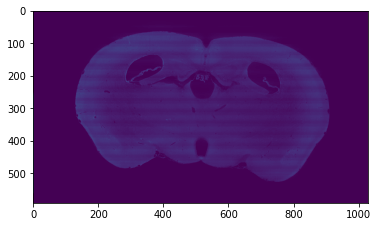

In [11]:
plt.imshow(img_np[:,:,500])

**Pre-processing**

In [12]:
def denoise_fft(image):
    """
    Apply circular mask to the image in FFT domain.
    """
    image_dtype = image.dtype
    img_float = image.astype(np.float32)

    H, W = img_float.shape
    img_fft = np.fft.fft2(img_float)/(W * H)

    img_fft = np.fft.fftshift(img_fft)

    center = [H//2, W//2]
    r = 200  # TODO hardcoded 500
    x, y = np.ogrid[:H, :W]
    mask_area = (x - center[0])**2 + (y - center[1])**2 >= r**2
    img_fft[mask_area] = 0

    img_fft = np.fft.ifftshift(img_fft)
    out_ifft = np.fft.ifft2(img_fft)

    image = (np.real(out_ifft) * W * H).astype(image_dtype)
    return image


def subtract_background_coronal_plane(img):
    """
    Subtract background from downsampled_standard.tif image, to compute overlap and nmi with atlas.

    Mask is computed from denoised image with low cutoff frequency
    (blured signigicantly) for better thresholding.
    """
    img_lf = denoise_fft(img)
    img_lf = img_lf.astype(np.float32)
    try:
        thr = threshold_triangle(img_lf)
    except:  # attempt to get argmax of an empty sequence
        return np.zeros_like(img).astype(np.uint16)

    mask = (img_lf > thr).astype(np.uint8)
    mask = (ndimage.binary_fill_holes(mask)).astype(np.uint8)
    kernel = disk(3)
    mask = (opening(mask, kernel)).astype(np.uint8)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)
    sizes = stats[1:, -1]
    nb_components -= 1
    for i in range(nb_components):
        if sizes[i] < 12000:
            mask[output == i + 1] = np.abs(mask[output == i + 1] - 1)

    return mask

In [18]:
def calculate_first_harmonic(image):
    """
    Calculate as argmax().
    """
    quant_5 = np.quantile(image.astype(np.float32), 0.05, axis=0)
    r_fft_transf = np.fft.rfft(quant_5)/quant_5.shape[0]
    first_harmonic = np.argmax(abs(r_fft_transf)[5:]) + 5
    return first_harmonic


def fft_2d_stripes_filter(image):
    image_dtype = image.dtype
    first_harmonic = calculate_first_harmonic(image)
    H, W = image.shape
    img_fft = np.fft.fft2(image.astype(np.float32))/(W * H) 
    img_fft = np.fft.fftshift(img_fft)

    mask = np.ones_like(img_fft).astype(np.uint8)
    mask[H // 2 - 1, :] = 0  # Removing horizontal line in the middle
    mask[H // 2, :] = 0  # Removing horizontal line in the middle
    mask[H // 2 + 1, :] = 0  # Removing horizontal line in the middle

    mask[:, W // 2 - 1] = 0  # Removing vertical line in the middle
    mask[:, W // 2] = 0  # Removing vertical line in the middle
    mask[:, W // 2 + 1] = 0  # Removing vertical line in the middle

    mask[H // 2 - 1, W // 2 - first_harmonic // 2 + 1 : W // 2 + first_harmonic // 2 - 1] = 1  # Retaining central region intact
    mask[H // 2, W // 2 - first_harmonic // 2 + 1 : W // 2 + first_harmonic // 2 - 1] = 1  # Retaining central region intact
    mask[H // 2 + 1, W // 2 - first_harmonic // 2 + 1 : W // 2 + first_harmonic // 2 - 1] = 1  # Retaining central region intact

    mask[H // 2 - first_harmonic + 1 : H // 2 + first_harmonic - 1, W // 2 - 1] = 1  # Retaining central region intact
    mask[H // 2 - first_harmonic + 1 : H // 2 + first_harmonic - 1, W // 2] = 1  # Retaining central region intact
    mask[H // 2 - first_harmonic + 1 : H // 2 + first_harmonic - 1, W // 2 + 1] = 1  # Retaining central region intact

    img_fft[mask==0] = 0
    img_fft = np.fft.ifftshift(img_fft)
    out_ifft = np.fft.ifft2(img_fft)
    image = (np.real(out_ifft) * W * H).astype(image_dtype)

    return image

**Pre-process every 2D coronal slice in the 3D dataset**

In [13]:
mask_bckgnd = np.zeros_like(img_np)
img_fft = np.zeros_like(img_np)

for x in range(img_np.shape[-1]):
    if x % 100 == 0:
        print(f"{x} of {img_np.shape[-1]}")
    sl = img_np[:,:,x]
    m = subtract_background_coronal_plane(sl)
    mask_bckgnd[:,:,x] = m
    sl_fft = fft_2d_stripes_filter(sl)
    sl_fft[m == 0] = 0
    img_fft[:,:,x] = sl_fft


**Display the mask of foreground/background**

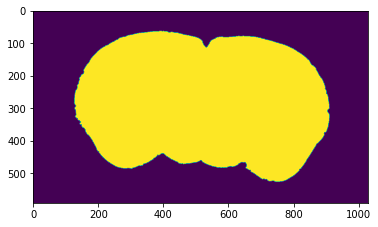

In [14]:
plt.imshow(mask_bckgnd[:,:,500])

**Display image after stripes and background removal**

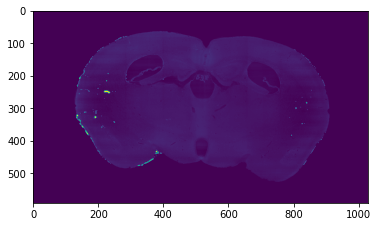

In [25]:
plt.imshow(img_fft[:,:,500])

**Register pre-processed brain using brainreg**

In [28]:
def launch_registration(input_file, output_folder, atlas, resolution, orientation):
    cmd = [
        'brainreg', input_file, output_folder,
        '-v', str(resolution[0]), str(resolution[1]), str(resolution[2]),
        '--orientation', orientation,
        '--atlas', atlas,
        '--save-original-orientation'
    ]

    ret = subprocess.run(cmd)

In [ ]:
resolution = [10, 10, 10]
orientation = "sla"
atlas = "allen_mouse_25um"
input_file = "/media/iana/hackathon/194061_red_mm_SLA_wo_bckgnd_v3.tif"
output_folder = "/media/iana/hackathon/brainreg_output_bgs"

launch_registration(input_file, output_folder, atlas, resolution, orientation)